In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
from wordcloud import WordCloud

# Завантаження потрібних ресурсів NLTK
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\geras.VADYM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\geras.VADYM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
data_fake = pd.read_csv('News_dataset/Fake.csv')
data_true = pd.read_csv('News_dataset/True.csv')

In [3]:
data_fake['class'] = 'fake'
data_true['class'] = 'true'

In [4]:
df_combined = pd.concat([data_fake, data_true], axis=0).reset_index(drop=True)
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
print("Розмір датасету:", df_combined.shape)
print("Кількість фейкових новин:", len(data_fake))
print("Кількість правдивих новин:", len(data_true))

print("\nТипи даних атрибутів:")
print(df_combined.dtypes)

Розмір датасету: (44898, 5)
Кількість фейкових новин: 23481
Кількість правдивих новин: 21417

Типи даних атрибутів:
title      object
text       object
subject    object
date       object
class      object
dtype: object


In [6]:
df_combined.head()

,title,text,subject,date,class
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",fake
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",true
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",true
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",fake
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",true


In [7]:
os.makedirs('dataset_analysis', exist_ok=True)

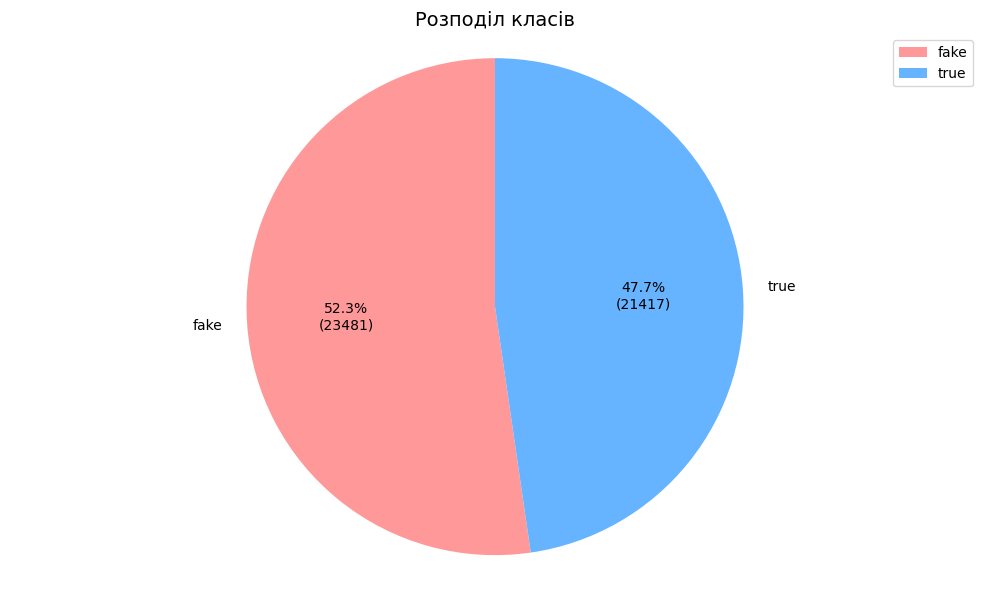

In [8]:
# Підрахунок кількості записів у кожному класі
class_counts = df_combined['class'].value_counts()

# Функція для форматування підпису з відсотком і абсолютною кількістю
def autopct_format(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute})"

# Візуалізація розподілу класів у вигляді кругової діаграми
plt.figure(figsize=(10, 6))
plt.pie(class_counts, 
        labels=['fake' if i == 'fake' else 'true' for i in class_counts.index], 
        autopct=lambda pct: autopct_format(pct, class_counts),
        startangle=90,
        colors=['#ff9999','#66b3ff'])

plt.title('Розподіл класів', fontsize=14)
plt.axis('equal')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('dataset_analysis/class_distribution_pie.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

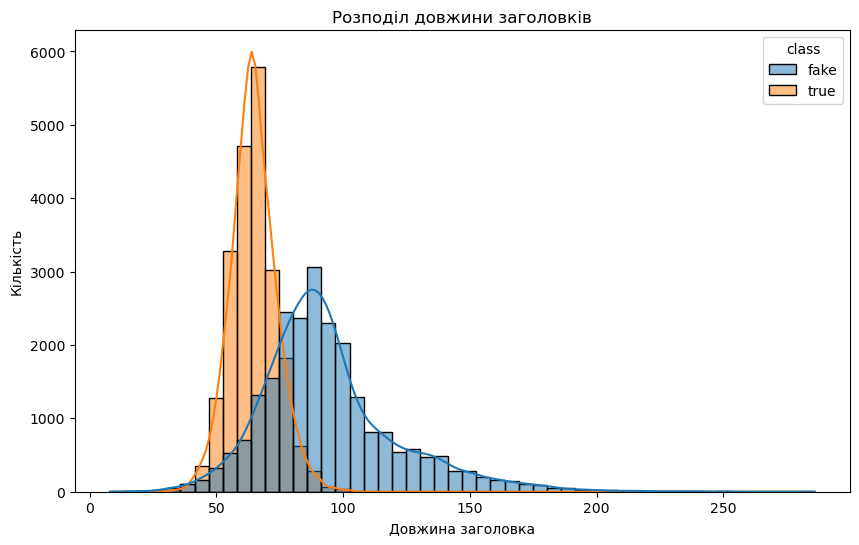

In [9]:
df_combined['title_length'] = df_combined['title'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df_combined, x='title_length', hue='class', kde=True, bins=50)
plt.title('Розподіл довжини заголовків')
plt.xlabel('Довжина заголовка')
plt.ylabel('Кількість')
plt.savefig('dataset_analysis/title_length_distribution.png')
plt.show()
plt.close()

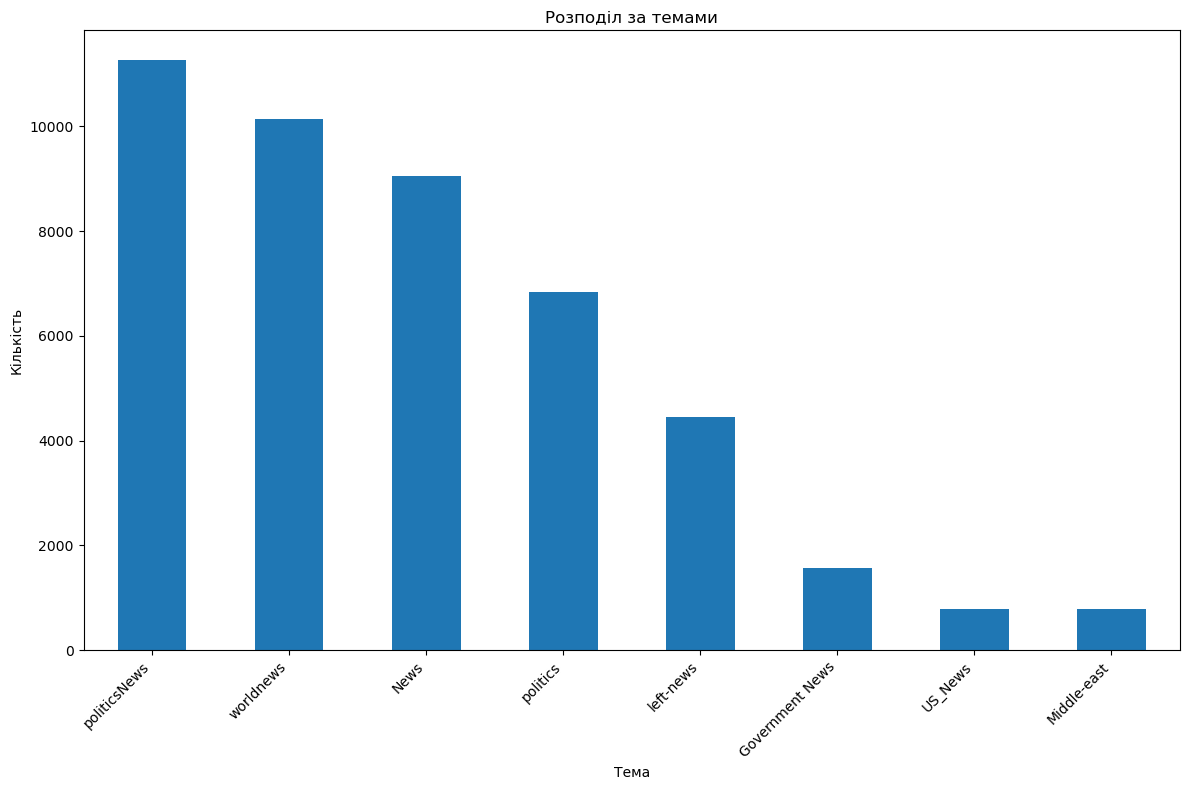

In [10]:
plt.figure(figsize=(12, 8))
df_combined['subject'].value_counts().plot(kind='bar')
plt.title('Розподіл за темами')
plt.xlabel('Тема')
plt.ylabel('Кількість')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('dataset_analysis/subject_distribution.png')
plt.show()
plt.close()

In [11]:
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))  
    tokens = [word for word in tokens if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    processed_text = ' '.join(tokens)
    
    return processed_text


# Аналіз найчастіших слів у фейкових новинах
stop_words = set(stopwords.words('english'))

def get_most_common_words(texts, n=20):
    all_words = []
    for text in texts:
        words = nltk.word_tokenize(clean_text(text))
        words = [word for word in words if word not in stop_words and len(word) > 2]
        all_words.extend(words)
    return Counter(all_words).most_common(n)

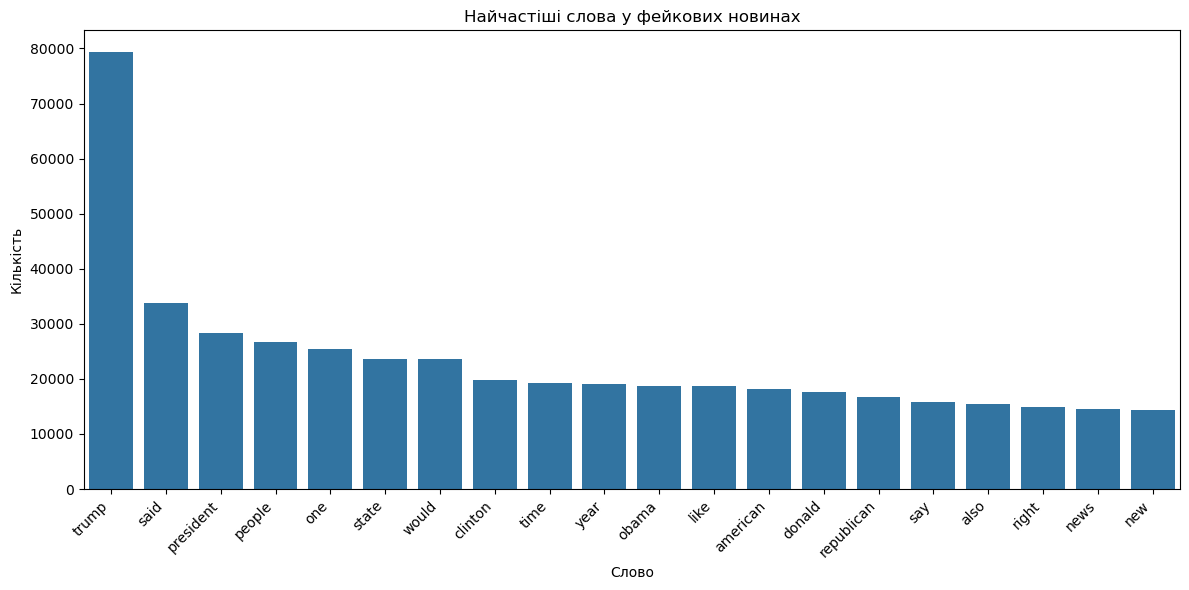

In [12]:
most_common_fake = get_most_common_words(data_fake['text'].tolist())
fake_words = pd.DataFrame(most_common_fake, columns=['word', 'count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='word', y='count', data=fake_words)
plt.title('Найчастіші слова у фейкових новинах')
plt.xlabel('Слово')
plt.ylabel('Кількість')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('dataset_analysis/common_words_fake.png')
plt.show()
plt.close()

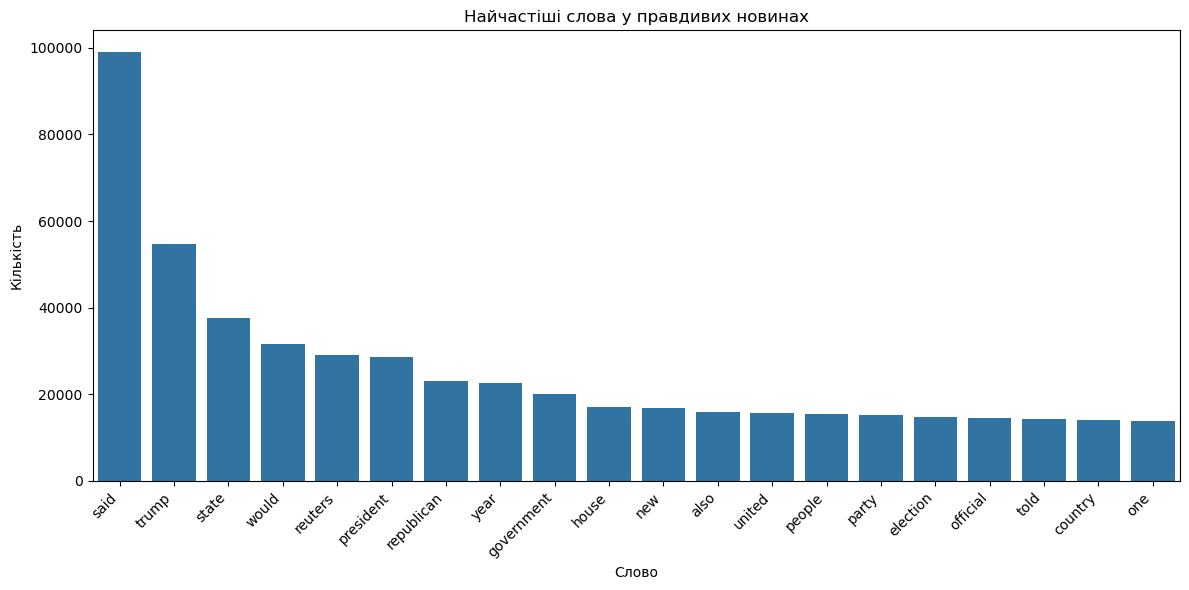

In [13]:
most_common_true = get_most_common_words(data_true['text'].tolist())
true_words = pd.DataFrame(most_common_true, columns=['word', 'count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='word', y='count', data=true_words)
plt.title('Найчастіші слова у правдивих новинах')
plt.xlabel('Слово')
plt.ylabel('Кількість')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('dataset_analysis/common_words_true.png')
plt.show()
plt.close()

In [14]:
def generate_wordcloud(text_list, title, filename):
    text = ' '.join([clean_text(text) for text in text_list])
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         stopwords=stop_words, max_words=100).generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    
    plt.show()
    
    plt.savefig(f'dataset_analysis/{filename}')

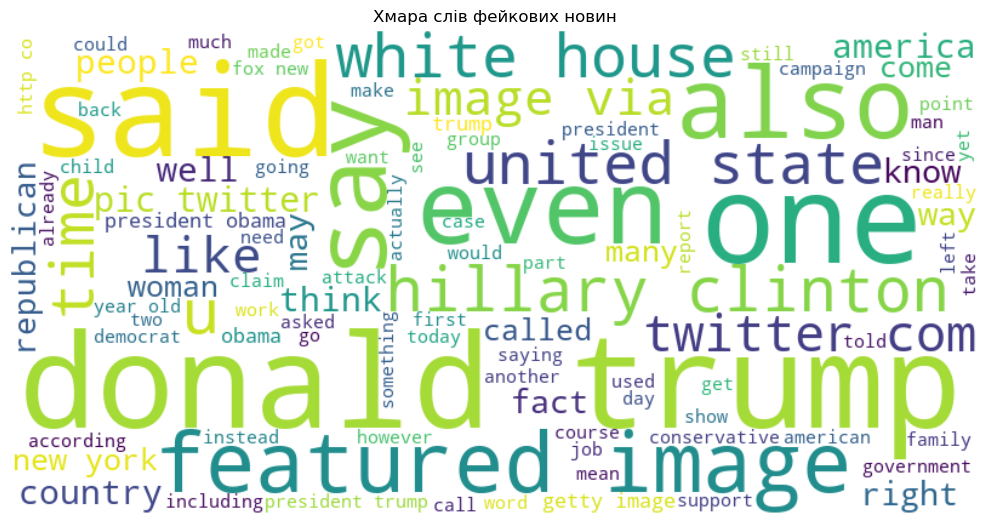

<Figure size 640x480 with 0 Axes>

In [15]:
generate_wordcloud(data_fake['text'].tolist(), 'Хмара слів фейкових новин', 'wordcloud_fake.png')

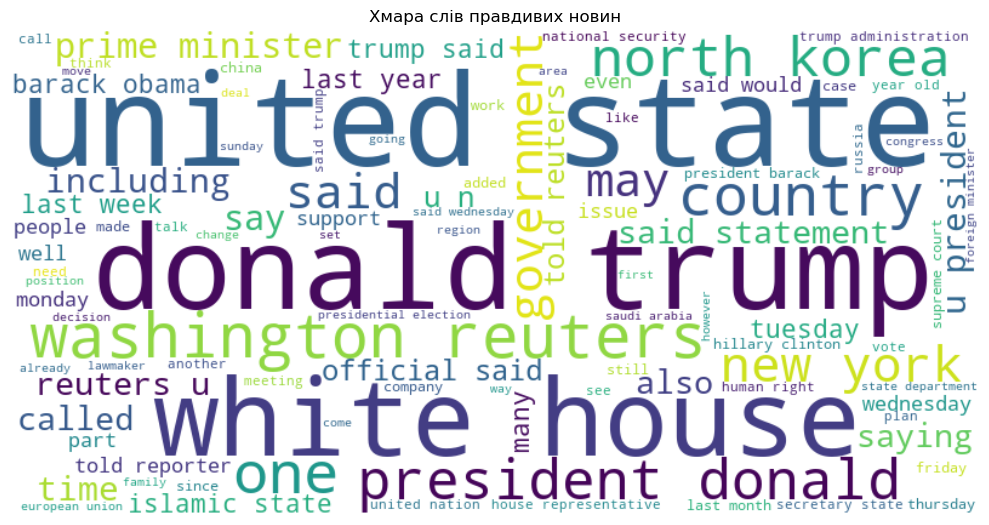

<Figure size 640x480 with 0 Axes>

In [16]:
generate_wordcloud(data_true['text'].tolist(), 'Хмара слів правдивих новин', 'wordcloud_true.png')